Copyright (c) 2015, 2016 [Sebastian Raschka](sebastianraschka.com)

https://github.com/rasbt/python-machine-learning-book

[MIT License](https://github.com/rasbt/python-machine-learning-book/blob/master/LICENSE.txt)

# Python Machine Learning - Code Examples

# Méthodes d'Ensemble : Combinaison de classifieurs

In [2]:
from IPython.display import Image
%matplotlib inline

In [3]:
# Added version check for recent scikit-learn 0.18 checks
from distutils.version import LooseVersion as Version
from sklearn import __version__ as sklearn_version

# Pourquoi les méthodes d'ensemble marchent ?
## Simulation de performances dans des conditions idéales (décorrélation des erreurs classifieurs) 

In [4]:
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = math.ceil(n_classifier / 2.0)
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [5]:
from scipy.misc import comb
import math

def ensemble_error(n_classifier, error):
    k_start = int(math.ceil(n_classifier / 2.0))
    probs = [comb(n_classifier, k) * error**k * (1-error)**(n_classifier - k)
             for k in range(k_start, n_classifier + 1)]
    return sum(probs)

In [6]:
print ensemble_error(n_classifier=1, error=0.25)
print ensemble_error(n_classifier=10, error=0.25)
print ensemble_error(n_classifier=100, error=0.25)


0.25
0.0781269073486
6.63850248348e-08


In [7]:
import numpy as np

error_range = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n_classifier=11, error=error)
              for error in error_range]

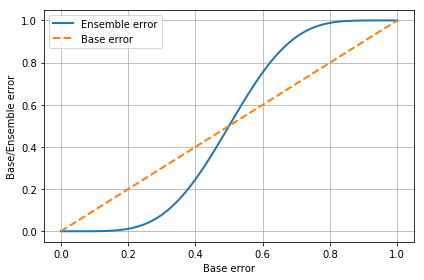

In [8]:
import matplotlib.pyplot as plt

plt.plot(error_range, 
         ens_errors, 
         label='Ensemble error', 
         linewidth=2)

plt.plot(error_range, 
         error_range, 
         linestyle='--',
         label='Base error',
         linewidth=2)

plt.xlabel('Base error')
plt.ylabel('Base/Ensemble error')
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
# plt.savefig('./figures/ensemble_err.png', dpi=300)
plt.show()

# Une méthode simple de vote majoritaire 

In [9]:
import numpy as np


## Implémentation de la classe Vote Majoritaire

In [10]:
## Completez les fonctions predict et predict_proba de MajorityVoteClassifier

from sklearn.base import BaseEstimator
from sklearn.base import ClassifierMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.base import clone
from sklearn.pipeline import _name_estimators
import numpy as np
import operator


class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self
        
       
    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        
        predicted_proba = []
        for clf in self.classifiers_:
            predicted_proba.append(clf.predict_proba(X))
        avg_proba = np.average(predicted_proba, axis=0)
        return avg_proba
    
        #Completez la fonction. Vous pouvez utiliser 
        #[clf.predict_proba(X) for clf in self.classifiers_]
        #pour obtenir les predictions des classifieurs
        
        
    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        
        # Methode probabiliste
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis = 1)
            return maj_vote
    
        # Methode vote
        elif self.vote == 'classlabel':
            predicted_class = []
            for clf in self.classifiers_:
                index_predicted_class = clf.predict(X)
                
            b = np.bincount(predicted_class)
            maj_vote = np.argmax(b)
            return maj_vote
        
        #Completez la fonction. Vous pouvez utiliser 
        #[clf.predict(X) for clf in self.classifiers_]
        #pour obtenir les predictions des classifieurs


    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

## Combinaison de différents algorithmes par vote majoritaire


In [11]:
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import train_test_split
else:
    from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X, y = iris.data[50:, [1, 2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test =\
       train_test_split(X, y, 
                        test_size=0.5, 
                        random_state=1)


### Performances des modèles isolés

In [12]:

import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
if Version(sklearn_version) < '0.18':
    from sklearn.cross_validation import cross_val_score
else:
    from sklearn.model_selection import cross_val_score

clf1 = LogisticRegression(penalty='l2', 
                          C=0.001,
                          random_state=0)

clf2 = DecisionTreeClassifier(max_depth=1,
                              criterion='entropy',
                              random_state=0)

clf3 = KNeighborsClassifier(n_neighbors=1,
                            p=2,
                            metric='minkowski')

pipe1 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()],
                  ['clf', clf3]])

clf_labels = ['Logistic Regression', 'Decision Tree', 'KNN']

print('10-fold cross validation:\n')
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf,
                             X=X_train,
                             y=y_train,
                             cv=10,
                             scoring='roc_auc')
    print("ROC AUC: %0.2f (+/- %0.2f) [%s]"
          % (scores.mean(), scores.std(), label))
    

10-fold cross validation:

ROC AUC: 0.92 (+/- 0.20) [Logistic Regression]
ROC AUC: 0.92 (+/- 0.15) [Decision Tree]
ROC AUC: 0.93 (+/- 0.10) [KNN]


### Performance de la combinaison

Utilisez MajorityVoteClassifier pour combiner les 3 classifieurs précédents


In [13]:
classifiers = [pipe1, clf2, pipe3]
test1 = MajorityVoteClassifier([pipe1, clf2, pipe3], 'classlabel')
test1.fit(X_train, y_train)
print test1.predict_proba(X_train)
print test1.predict(X_train)

[[ 0.83758476  0.16241524]
 [ 0.19106267  0.80893733]
 [ 0.83452208  0.16547792]
 [ 0.83414448  0.16585552]
 [ 0.19355175  0.80644825]
 [ 0.83509608  0.16490392]
 [ 0.83528639  0.16471361]
 [ 0.19296252  0.80703748]
 [ 0.83625306  0.16374694]
 [ 0.1921952   0.8078048 ]
 [ 0.83644028  0.16355972]
 [ 0.19315588  0.80684412]
 [ 0.19238854  0.80761146]
 [ 0.83567307  0.16432693]
 [ 0.83452208  0.16547792]
 [ 0.19315284  0.80684716]
 [ 0.8339511   0.1660489 ]
 [ 0.19353044  0.80646956]
 [ 0.83318065  0.16681935]
 [ 0.1927722   0.8072278 ]
 [ 0.19182679  0.80817321]
 [ 0.52859806  0.47140194]
 [ 0.19411665  0.80588335]
 [ 0.1950744   0.8049256 ]
 [ 0.8373915   0.1626085 ]
 [ 0.1950744   0.8049256 ]
 [ 0.83376077  0.16623923]
 [ 0.1912651   0.8087349 ]
 [ 0.19201404  0.80798596]
 [ 0.83585423  0.16414577]
 [ 0.83662446  0.16337554]
 [ 0.83414143  0.16585857]
 [ 0.83451904  0.16548096]
 [ 0.83549495  0.16450505]
 [ 0.52743476  0.47256524]
 [ 0.19162434  0.80837566]
 [ 0.83413839  0.16586161]
 

ValueError: attempt to get argmax of an empty sequence

Appliquez la fonction get_params() sur votre MajorityVoteClassifier.

In [14]:
test1.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None,
             min_impurity_decrease=0.0, min_impurity_split=None,
             min_samples_leaf=1, min_samples_split=2,
             min_weight_fraction_leaf=0.0, presort=False, random_state=0,
             splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_impurity_decrease': 0.0,
 'decisiontreeclassifier__min_impurity_split': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__presort': False,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 

## Piste d'amélioration 

# Combinaison par bagging et boosting

Utilisez les données de la base Iris pour tester le bagging et le boosting.

Vous utiliserez respectivement BaggingClassifier et AdaBoostClassifier.
Utilisez des arbres de décision (DecisionTreeClassifier) comme classifieurs faibles.
Faites une gridsearch pour évaluer l'impact des different parametres.


## Données iris


In [16]:
from sklearn.datasets import load_digits, load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#digits = load_digits()

dataset = load_iris()
print dataset.data.shape
print dataset.target.shape

X, y= dataset.data, dataset.target

###############################################

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=0)


from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)


(150, 4)
(150,)
